In [ ]:
!pip install pydot --quiet
!pip install tensorflow-datasets --quiet
!pip install transformers --quiet

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-039504dc-70da-dce7-8155-835b0eb72471)


In [ ]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate, Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel, GPT2Config
import sklearn as sk
import os
from nltk.data import find
import matplotlib.pyplot as plt
import re
import tensorflow as tf

In [ ]:
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

train_examples, train_labels = next(iter(train_data.batch(20000)))
val_examples, val_labels = next(iter(train_data.batch(5000)))
test_examples, test_labels = next(iter(test_data.batch(1000)))

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

config = GPT2Config.from_pretrained("gpt2", output_hidden_states=True)
gpt2_model = TFGPT2LMHeadModel.from_pretrained("gpt2", config=config)
tokenizer.pad_token = tokenizer.eos_token
MAX_SEQUENCE_LENGTH = 100

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [ ]:
#Embedding size of GPT2 tokenizer: 768
#Dictionary size of GPT2 tokenizer: 50257


train_examples_str = [x.decode('utf-8') for x in train_examples.numpy()]
val_examples_str = [x.decode('utf-8') for x in val_examples.numpy()]
test_examples_str = [x.decode('utf-8') for x in test_examples.numpy()]

#training data
gpt_train_tokenized = tokenizer(train_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

gpt_train_inputs = {
    'input_ids': gpt_train_tokenized['input_ids'],
    'attention_mask': gpt_train_tokenized['attention_mask']
}

gpt_train_labels = np.array(train_labels)


#validation data
gpt_val_tokenized = tokenizer(val_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

gpt_val_inputs = {
    'input_ids': gpt_val_tokenized['input_ids'],
    'attention_mask': gpt_val_tokenized['attention_mask']
}

gpt_val_labels = np.array(val_labels)

#testing data
gpt_test_tokenized = tokenizer(test_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

gpt_test_inputs = {
    'input_ids': gpt_test_tokenized['input_ids'],
    'attention_mask': gpt_test_tokenized['attention_mask']
}

gpt_test_labels = np.array(test_labels)


In [ ]:
#24 layers of transformer
#A drop out layer + dense layer with 100 hidden layer size on top + final layer with sigmoid as activation function


def create_gpt_last_model(gpt_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with gpt. Use the last token output for classification purposes.
    """

    gpt_model.trainable = True #True

    #input layers of gpt, shape (batch, max_sequence_length), model will be fit with gpt_train_inputs
    input_ids = Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_sequence_length,), dtype=tf.int32, name='attention_mask')

    # GPT-2 model
    #model.generate() for iteratively generating (autoregressive)
    #we only do it one time.
    gpt2_outputs = gpt_model(input_ids=input_ids, attention_mask=attention_mask)

    # Use the last hidden state of the last transformer layer for classification, ingore linear layer and softmax layer
    # Select the last token of hidden state
    last_hidden_state_last_token = gpt2_outputs.logits[:, -1, :]

    #Add a dropout layer
    x = Dropout(dropout)(last_hidden_state_last_token)

    #Add a fully connected layer for classification
    x = Dense(hidden_size, activation='relu')(x)

    #Final output layer for classification, assuming it's binary task
    output = Dense(1, activation='sigmoid')(x)


    # Create the model
    classification_model = Model(inputs=[input_ids, attention_mask], outputs=output)


    #Model complie
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='binary_crossentropy',
                                 metrics=['accuracy'])

    return classification_model


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
gpt_logit_model_classification = create_gpt_last_model(gpt2_model)

history = gpt_logit_model_classification.fit(gpt_train_inputs,
                    gpt_train_labels,
                    epochs=2, #2
                    batch_size=8,
                    validation_data=(gpt_val_inputs, gpt_val_labels))

Epoch 1/2
2500/2500 [==============================] - 762s 294ms/step - loss: 2.0575 - accuracy: 0.6130 - val_loss: 0.4004 - val_accuracy: 0.8250
Epoch 2/2
2500/2500 [==============================] - 734s 294ms/step - loss: 0.4860 - accuracy: 0.7948 - val_loss: 0.3947 - val_accuracy: 0.8634


In [ ]:
#Model before zeroing out
gpt_logit_model_classification.evaluate(gpt_test_inputs, gpt_test_labels)

32/32 [==============================] - 13s 334ms/step - loss: 0.4284 - accuracy: 0.8490


[0.42840564250946045, 0.8489999771118164]

In [ ]:
import time

start_time = time.time()
prediction = gpt_logit_model_classification.predict(gpt_test_inputs)
end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))

32/32 [==============================] - 14s 347ms/step
Elapsed time: 23.38 seconds


In [ ]:
# Example test reviews
"""
1. Identifying Emotional Tone
Sub-Task: Determine the emotional tone of the review (e.g., positive, negative, neutral).
Test Reviews:
    EX1 "The movie's breathtaking scenery and exceptional soundtrack added depth to its rich storytelling." -> Positive Tone
    EX2 "The film was a letdown with its lackluster plot and uninspired performances." -> Negative Tone
2. Analyzing Subjective Statements
Sub-Task: Detect subjective statements or opinions in the review.
Test Reviews:
    EX3 "In my opinion, the film's portrayal of historical events was highly inaccurate." -> Subjective
    EX4 "The movie won three Academy Awards, including Best Picture." -> Objective
3. Evaluating Specific Aspects (Acting, Plot, Cinematography)
Sub-Task: Assess specific aspects of the movie like acting quality, plot development, and cinematography.
Test Reviews:
    EX5 "The acting was superb, with each character bringing depth and emotion to the screen." -> Positive Acting
    EX6 "The plot was predictable and lacked originality, making the movie quite boring." -> Negative Plot
4. Recognizing Extremes in Sentiment
Sub-Task: Identify reviews with extremely positive or negative sentiments.
Test Reviews:
    EX7 "This is possibly the worst movie ever made, with no redeeming qualities whatsoever." -> Extremely Negative
    EX8 "An absolute masterpiece, every moment was captivating and a joy to watch." -> Extremely Positive
5. Detecting Sarcasm or Irony
Sub-Task: Detect sarcasm or irony, which can often invert the apparent sentiment of a statement.
Test Reviews:
    EX9 "Oh great, another predictable rom-com, just what the world needs." -> Sarcasm
    EX10 "I loved how the movie ended abruptly without resolving any plot points." -> Irony
"""

# First reivews is positive tone and the second is negative tone
test_reviews = [
    "In my opinion, the film's portrayal of historical events was highly inaccurate.",
    "The movie won three Academy Awards, including Best Picture.",
    "In my opinion, the film's portrayal of historical events was highly inaccurate.",
    "The movie won three Academy Awards, including Best Picture.",
    "The acting was superb, with each character bringing depth and emotion to the screen.",
    "The plot was predictable and lacked originality, making the movie quite boring.",
    "This is possibly the worst movie ever made, with no redeeming qualities whatsoever.",
    "An absolute masterpiece, every moment was captivating and a joy to watch.",
    "Oh great, another predictable rom-com, just what the world needs.",
    "I loved how the movie ended abruptly without resolving any plot points."
]

In [ ]:
def extract_transformer_outputs(model, tokenizer, text, max_length=MAX_SEQUENCE_LENGTH):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="tf", max_length=max_length, padding=True, truncation=True)

    # Get outputs from the model
    outputs = model(**inputs, output_hidden_states=True)

    # Extract the hidden states from each layer
    hidden_states = outputs.hidden_states

    return hidden_states


# Example usage
hidden_states = extract_transformer_outputs(gpt2_model, tokenizer, test_reviews)
print(hidden_states)
print(len(hidden_states))

(<tf.Tensor: shape=(10, 16, 768), dtype=float32, numpy=
array([[[-3.31244692e-02, -2.75187343e-01,  1.08748525e-01, ...,
          1.99037895e-01, -3.70798334e-02, -1.05327368e-02],
        [ 1.79998502e-01,  5.36328852e-02, -2.54170746e-02, ...,
          8.41936842e-02,  1.15722775e-01,  2.74957810e-02],
        [ 1.66623279e-01, -6.95171207e-03,  3.70554477e-02, ...,
         -1.32766098e-01,  1.76915135e-02, -8.86920542e-02],
        ...,
        [-8.80430080e-03,  9.04437825e-02,  1.97137147e-01, ...,
         -1.49239480e-01,  2.43238714e-02,  8.35666135e-02],
        [ 4.75492217e-02,  8.79946630e-03,  1.23632759e-01, ...,
         -7.13714734e-02,  4.89826016e-02,  9.65108499e-02],
        [ 5.40797748e-02, -6.06381893e-03,  1.34249732e-01, ...,
          7.08856620e-04,  1.50670081e-01,  1.15978584e-01]],

       [[-8.45964774e-02, -2.17638597e-01,  7.07410499e-02, ...,
          2.03571208e-02,  2.10232083e-02,  5.84937856e-02],
        [ 4.72831130e-02, -9.31925997e-02,  1.2

In [ ]:
#simiarity for layers

import numpy as np
from numpy.linalg import norm

def calculate_similarities(hidden_states):

    # Number of examples and layers
    num_examples, num_layers = hidden_states[0].shape[0], len(hidden_states)

    # Initializing arrays to store the results
    cosine_similarities = np.zeros((num_examples, num_layers))
    dot_products = np.zeros((num_examples, num_layers))

    # Final layer's last token output
    # (layers, examples, seq, embedding dimension)
    final_layer_output = hidden_states[-1]

    # Calculating similarities by layers
    for i in range(num_layers):
        for j in range(num_examples):
            # Extracting the CLS output for the current layer and example
            current_output = hidden_states[i][j][-1]

            # Cosine Similarity
            cosine_similarities[j, i] = np.dot(current_output, final_layer_output[j][-1]) / (norm(current_output) * norm(final_layer_output[j][-1]))

    return cosine_similarities


cosine_similarities_layer = calculate_similarities(hidden_states)
print(cosine_similarities_layer.shape)
#10 examples, 13 cosine similarirty of 13 layers. last one will be 1.
#(10, 13)

(10, 13)


In [ ]:
for var in gpt2_model.variables:
    print(f"{var.name}: {var.shape}")

In [ ]:
def extract_ffn_second_dense_weights(gpt2_model):
    """
    Extracts the kernel weights from the second dense layer of the FFN in each transformer layer of the gpt model.
    """
    ffn_weights = []
    # Loop through each transformer layer and construct the variable name
    for layer_num in range(gpt2_model.config.num_hidden_layers):
        # Construct the variable name for the second dense layer weights in the current layer
        weight_name = f"tfgpt2lm_head_model/transformer/h_._{layer_num}/mlp/c_proj/weight:0" #f"tfgpt2lm_head_model_1/transformer/h_._{layer_num}/mlp/c_proj/weight:0"

        # Find and extract the variable
        for var in gpt2_model.variables:
            if var.name == weight_name:
                print(var)
                weights = var.numpy()  # Convert to numpy array
                ffn_weights.append(weights)
                break  # Move to the next layer once the weights are found

    return ffn_weights

ffn_weights = extract_ffn_second_dense_weights(gpt2_model)

<tf.Variable 'tfgpt2lm_head_model/transformer/h_._0/mlp/c_proj/weight:0' shape=(3072, 768) dtype=float32, numpy=
array([[-0.10640587,  0.15262553,  0.03359779, ...,  0.16453362,
        -0.04087063,  0.12173471],
       [ 0.03767035, -0.05911045,  0.08402098, ...,  0.09362248,
        -0.09900269, -0.0383853 ],
       [-0.0751109 ,  0.00819661, -0.09503949, ...,  0.05139565,
        -0.00313113, -0.03031024],
       ...,
       [-0.10314862,  0.0084471 , -0.02996467, ...,  0.0124373 ,
         0.00169209, -0.01738732],
       [-0.02953189, -0.03279107, -0.00758716, ...,  0.09013154,
        -0.04486695,  0.0052709 ],
       [-0.02159979,  0.08179252,  0.07957918, ..., -0.05555193,
        -0.00797795, -0.08200686]], dtype=float32)>
<tf.Variable 'tfgpt2lm_head_model/transformer/h_._1/mlp/c_proj/weight:0' shape=(3072, 768) dtype=float32, numpy=
array([[ 0.10997669, -0.02686073, -0.03303344, ..., -0.00979511,
        -0.03103735, -0.06873523],
       [-0.21017483, -0.1568364 , -0.0895923 

In [ ]:
# input of EX1. hidden_states  # (layers, examples, seq, embedding dimension)
gpt_last_token = hidden_states[-1][0][-1]

def compute_cosine_similarities(gpt_last_token, ffn_weights):
    # Normalize the CLS token output
    cls_norm = np.linalg.norm(gpt_last_token)
    cls_token_normalized = gpt_last_token / cls_norm

    cosine_similarities = []

    for layer_weights in ffn_weights:
        # Transpose the weights to align dimensions with CLS token output
        # layer_weights shape is (3072, 768), after transpose it will be (768, 3072)
        transposed_weights = layer_weights.T

        # Normalize the neuron weights
        neuron_norms = np.linalg.norm(transposed_weights, axis=0)
        normalized_neurons = transposed_weights / neuron_norms

        # Compute the dot product
        dot_product = np.dot(cls_token_normalized, normalized_neurons)

        cosine_similarities.append(dot_product)

    return cosine_similarities

#'gpt_last_token' is the last token of final transformer layer . shape of (768,)
# And 'ffn_weights' is a list of arrays, each of shape (3072, 768)
cosine_similarities_neurons = compute_cosine_similarities(gpt_last_token, ffn_weights)

print(len(cosine_similarities_neurons))
print(cosine_similarities_neurons[0].shape)

#12 layers, 3072 neurons
#a list of 12 [] and each has 3072 in length

12
(3072,)


In [ ]:
#Zero out weights strategically

"""
Based on the decoder-based gpt's nature of information delivery, zeroing-out bar for first 5 layers are higher (according to layer similarity) and gradually getting lower in the following layers.
As for the layer 11, since it is the decision-making layer, we can zero out most neurons except preseved ones.

"""

In [ ]:
#input 0, layer 1, first layer of transfomrers
for layer in range(1, 13):
    print(cosine_similarities_layer[5][layer])

#try to come up with an equation for layer similarity and a bar for neurons to be removed.

0.08073993027210236
0.08839960396289825
0.09865099936723709
0.10909189283847809
0.10344599932432175
0.11567986756563187
0.13689970970153809
0.1637384593486786
0.19258950650691986
0.18796499073505402
0.19811399281024933
1.0


In [ ]:
#input 0, layer 1, first layer of transfomrers
#output: masked_neurons_list
#input: cosine_similarities_neurons, cosine_similarities_layer, alpha
#if the last token of layer N is close to last layer, it means Nth layer get the right information to make the call and neruons in this layer can handle the task properly,
#As a result, neurons having low simiarlarity in this layer can be removed. The bar can be slightly higher
#cosine similarity can be negative, cos_sin = 0 irrelavent, -1~0, 0~1

def pruning_strategy(cosine_similarities_neurons, cosine_similarities_layer, alpha):
    masked_neurons_list = [[] for i in range(12)]
    for layer in range(5):
        for num, simi in enumerate(cosine_similarities_neurons[layer]):
            if cosine_similarities_layer[5][layer]*alpha > simi > -cosine_similarities_layer[5][layer]*alpha:
                masked_neurons_list[layer].append(num)

        print(f"Threshold of pruning {cosine_similarities_layer[5][layer]*alpha}")
        print(f"number of neruons being masked in layer {layer}: {len(masked_neurons_list[layer])}")

    #layer 11
    for layer in range(5,12):
        for num, simi in enumerate(cosine_similarities_neurons[layer]):
            if simi < 3*cosine_similarities_layer[5][layer]*alpha:
                masked_neurons_list[layer].append(num)
        print(f"Threshold of pruning {cosine_similarities_layer[5][layer]*alpha}")
        print(f"number of neruons being masked in layer {layer}: {len(masked_neurons_list[layer])}")

    return masked_neurons_list

masked_neurons_list = pruning_strategy(cosine_similarities_neurons, cosine_similarities_layer, alpha=0.15)
print(masked_neurons_list)

Threshold of pruning -0.02292773276567459
number of neruons being masked in layer 0: 0
Threshold of pruning 0.005978638306260109
number of neruons being masked in layer 1: 353
Threshold of pruning 0.006234094686806202
number of neruons being masked in layer 2: 404
Threshold of pruning 0.00878318902105093
number of neruons being masked in layer 3: 532
Threshold of pruning 0.01154554970562458
number of neruons being masked in layer 4: 724
Threshold of pruning 0.012514302134513855
number of neruons being masked in layer 5: 2537
Threshold of pruning 0.014355476573109626
number of neruons being masked in layer 6: 2614
Threshold of pruning 0.018847954273223878
number of neruons being masked in layer 7: 2791
Threshold of pruning 0.02213795632123947
number of neruons being masked in layer 8: 2858
Threshold of pruning 0.01988786235451698
number of neruons being masked in layer 9: 2723
Threshold of pruning 0.0183973990380764
number of neruons being masked in layer 10: 2388
Threshold of pruning 0

In [ ]:
#zero out the weights except presrved neurons.
preserved_neuron_list = [[],
                       [],
                       [],
                       [],
                       [],
                       [],
                       [],
                       [],
                       [],
                       [],
                       [804, 1410, 1521, 1783, 2931],
                       [309, 458, 480, 598, 796, 847, 869, 975, 1120, 1126, 1231, 1289, 1322, 1428, 1575, 1637, 1860, 1998, 2375, 2378, 2600, 2822]]

num_neurons = 3072
masks = []


for i, masked_neurons in enumerate(masked_neurons_list):
    mask = np.ones(num_neurons)
    if masked_neurons not in preserved_neuron_list[i]:
      mask[masked_neurons] = 0
      masks.append(mask)

In [ ]:
#zero out -> quantization + sparse matrix pruning
# Assuming bert_model is your pre-trained BERT model
#tf_bert_model/bert/encoder/layer_._0/output/dense/kernel
#  f"tfgpt2lm_head_model/transformer/h_._{layer_num}/mlp/c_proj/weight:0"


for var in gpt2_model.variables:
    if 'mlp/c_proj/weight' in var.name:
        # Extract layer number from variable name
        layer_num = int(var.name.split('/')[2].split('_')[2])

        # Get the current weights
        weights = var.numpy()

        # Apply the mask #(3072,)
        mask = masks[layer_num]
        weights *= mask.reshape(-1, 1)  # Reshape mask and apply to weights

        # Assign the modified weights back to the variable
        var.assign(weights)


In [ ]:
#to check in if the weights are correctly zero out
for var in gpt2_model.variables:
    if 'mlp/c_proj/weight' in var.name:
        print(var.name, var.numpy()[0:3, 0:3])  # Print a small section of the weights

In [ ]:
#bert_model has been zeroed out.
gpt_logit_model_classification.evaluate(gpt_test_inputs, gpt_test_labels)


#            accuracy process time (1000 inputs) 86.7, 86.3, 83.6, 80.8, 76.3, 66.7, 78.3, 83.7, 82.9, 82.0, 68.4     23.1, 20.54, 20.55, 20.65, 20.6, 20.53, 20.53, 12.98 20.54, 20.53, 12.54

# 0%        --  0.825 23.6
#alpha 0.01 --  0.48 10.28 (Remove all negative as well) (0.825 23.6)

# 0%        --  0.867, 23.1
#alpha 0.05  -- 0.863 20.54 (0.867, 23.1) (3times only in layer 11 )    5640
#alpha 0.075 --  0.836 20.55 (0.867, 23.1) (3times only in layer 11 )   5965
#alpha 0.1 --   0.808 20.65 (0.867, 23.1) (3times only in layer 11 )    7554
#alpha 0.125 -- 0.763 20.6  (0.867, 23.1) (3times only in layer 11 )    9907
#alpha 0.15 --  0.667 20.53 (0.867, 23.1) (3times only in layer 11 )    11668
#alpha 0.15 -- 0.783  20.53 (0.867, 23.1)(with layer 10+11)             13074
#alpha 0.15 -- 0.837  12.98 (0.867, 23.1)(with layer 9+10+11)           15224 x
#alpha 0.15 -- 0.829  20.54 (0.867, 23.1)(with layer 8+9+10+11)         17607
#alpha 0.15 -- 0.820  20.53 (0.867, 23.1)(with layer 7+8+9+10+11)       23715
#alpha 0.15 -- 0.684  12.54 (0.867, 23.1)(with layer 6+7+8+9+10+11)     24388 x


 #some neruons in the layer10 are stop model from getting correct answer...


#84.9, 83.3, 77.3, 80.5, 78.7, 76.7, 81.3, 78.7, 77.8, 73.5, 72.5, 74.9
#23.38, 20.69, 20.52, 20.53, 20.53, 10.93, 10.68, 10.69, 20.66, 20.52, 10.71, 20.52

#alpha 0.05  -- 0.833, 20.69  (0.849,23.38) (layer 11)                 3905
#alpha 0.075 -- 0.773, 20.52 (0.816,24.08) (layer 11)                  6175
#alpha 0.1 --   0.805, 20.53 (0.816,24.08) (layer 11)                  6841
#alpha 0.125 -- 0.787, 20.53 (0.816,24.08) (layer 11)                  7980
#alpha 0.15 --  0.767, 10.93/10.62/20.55 (0.816,24.08) (layer 11)      9588
#alpha 0.15 --  0.813, 10.68/10.76/20.52 (0.816,24.08) (layer 10,11)   11596
#alpha 0.15 --  0.787, 10.69/20.54 (0.816,24.08) (layer 9,10,11)       12384
#alpha 0.15 --  0.778, 20.66 (0.816,24.08) (layer 8,9,10,11)           15641
#alpha 0.15 --  0.735, 20.52 (0.816,24.08) (layer 7,8,9,10,11)         18469
#alpha 0.15 --  0.725, 10.71/20.55 (0.816,24.08) (layer 6,7,8,9,10,11) 23045
#alpha 0.15 --  0.749, 20.52 (0.816,24.08) (layer 5,6,7,8,9,10,11)     23625

#alpha 0.1  -- 0.584  12.47 (0.792, 23.04) (layer 9.10,11)
#alpha 0.125  -- 0.554  20.52 (0.792, 23.04) (layer 9,10,11)
#alpha 0.15  -- 0.547 20.52 (0.792, 23.04) (layer 9,10,11)

#alpha 0.05  -- 0.817, 20.53 (0.816,24.08) (layer 9,10,11)
#alpha 0.075 -- 0.822, 20.52 (0.816,24.08) (layer 9,10,11)
#alpha 0.1 --   0.817, 20.52 (0.816,24.08) (layer 9,10,11)
#alpha 0.125 -- 0.818, 20.54  (0.816,24.08) (layer 9,10,11)
#alpha 0.15 --  0.817 20.52 (0.816,24.08) (layer 9,10,11)
#alpha 0.15 --  0.819 20.52 (0.816,24.08) (layer 8, 9,10,11)
#alpha 0.15 --  0.828  20.53 (0.816,24.08) (layer 7, 8,9,10,11)
#alpha 0.15 --  0.822  10.45/10.6 (0.816,24.08) (layer 6,7,8,9,10,11)
#alpha 0.15 --  0.768  20.53 (0.816,24.08) (layer 5,6,7,8,9,10,11)
#alpha 0.15 --  0.768 20.52 (0.816,24.08) (layer 4,5,6,7,8,9,10,11)
#alpha 0.15 --  0.72 20.63 (0.816,24.08) (layer 3,4,5,6,7,8,9,10,11)

#There are some neruons in layer 9,10 are hindering model from getting correct answer
#lots neuron in layer 7,8 can also be pruned off since they are literally useless
#but in layer6, if you prune off too much neuron, then it may affect the ability of capturing patterns.
#it is shown in the layer similarity in the plot of input5, input 5 can reveal the mechanism of information delivery inside the model (input5 = Negative plotting)
# But the accuracy is by testing data.
# Re test it again using best hyperparameter layer 9~11 and alpha =0.1, 0.125, 0.15
# scan top down and bottom up.
# the inference time fluate a bit, don't know why

32/32 [==============================] - 11s 330ms/step - loss: 1.8163 - accuracy: 0.7490


[1.8162636756896973, 0.7490000128746033]

In [ ]:
import time

start_time = time.time()
prediction = gpt_logit_model_classification.predict(gpt_test_inputs)
end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))

32/32 [==============================] - 11s 340ms/step
Elapsed time: 20.52 seconds


In [ ]:
"""
alpha 0.05  -- 0.817, 20.53 (0.849,23.38) (layer 11)
Threshold of pruning -0.007642577588558197
number of neruons being masked in layer 0: 0
Threshold of pruning 0.0019928794354200363
number of neruons being masked in layer 1: 130
Threshold of pruning 0.002078031562268734
number of neruons being masked in layer 2: 133
Threshold of pruning 0.0029277296736836436
number of neruons being masked in layer 3: 183
Threshold of pruning 0.003848516568541527
number of neruons being masked in layer 4: 236
Threshold of pruning 0.004171434044837952
number of neruons being masked in layer 5: 241
Threshold of pruning 0.004785158857703209
number of neruons being masked in layer 6: 284
Threshold of pruning 0.0062826514244079595
number of neruons being masked in layer 7: 375
Threshold of pruning 0.007379318773746491
number of neruons being masked in layer 8: 374
Threshold of pruning 0.006629287451505661
number of neruons being masked in layer 9: 332
Threshold of pruning 0.0061324663460254674
number of neruons being masked in layer 10: 187
Threshold of pruning 0.007414974272251129
number of neruons being masked in layer 11: 1430


3,905

alpha 0.075 -- 0.822, 20.52 (0.816,24.08) (layer 11)
Threshold of pruning -0.011463866382837294
number of neruons being masked in layer 0: 0
Threshold of pruning 0.0029893191531300545
number of neruons being masked in layer 1: 178
Threshold of pruning 0.003117047343403101
number of neruons being masked in layer 2: 198
Threshold of pruning 0.004391594510525465
number of neruons being masked in layer 3: 269
Threshold of pruning 0.00577277485281229
number of neruons being masked in layer 4: 367
Threshold of pruning 0.006257151067256927
number of neruons being masked in layer 5: 358
Threshold of pruning 0.007177738286554813
number of neruons being masked in layer 6: 446
Threshold of pruning 0.009423977136611939
number of neruons being masked in layer 7: 547
Threshold of pruning 0.011068978160619735
number of neruons being masked in layer 8: 579
Threshold of pruning 0.00994393117725849
number of neruons being masked in layer 9: 496
Threshold of pruning 0.0091986995190382
number of neruons being masked in layer 10: 295
Threshold of pruning 0.011122461408376694
number of neruons being masked in layer 11: 1632

6175

alpha 0.1 --   0.817, 20.52 (0.816,24.08) (layer 11)
Threshold of pruning -0.015285155177116394
number of neruons being masked in layer 0: 0
Threshold of pruning 0.003985758870840073
number of neruons being masked in layer 1: 241
Threshold of pruning 0.004156063124537468
number of neruons being masked in layer 2: 277
Threshold of pruning 0.005855459347367287
number of neruons being masked in layer 3: 363
Threshold of pruning 0.007697033137083054
number of neruons being masked in layer 4: 499
Threshold of pruning 0.008342868089675904
number of neruons being masked in layer 5: 493
Threshold of pruning 0.009570317715406418
number of neruons being masked in layer 6: 586
Threshold of pruning 0.012565302848815919
number of neruons being masked in layer 7: 710
Threshold of pruning 0.014758637547492981
number of neruons being masked in layer 8: 770
Threshold of pruning 0.013258574903011322
number of neruons being masked in layer 9: 666
Threshold of pruning 0.012264932692050935
number of neruons being masked in layer 10: 370
Threshold of pruning 0.014829948544502258
number of neruons being masked in layer 11: 1816

6841

alpha 0.125 -- 0.818, 20.54  (0.816,24.08) (layer 11)
Threshold of pruning -0.019106443971395493
number of neruons being masked in layer 0: 0
Threshold of pruning 0.004982198588550091
number of neruons being masked in layer 1: 296
Threshold of pruning 0.005195078905671835
number of neruons being masked in layer 2: 339
Threshold of pruning 0.007319324184209108
number of neruons being masked in layer 3: 442
Threshold of pruning 0.009621291421353817
number of neruons being masked in layer 4: 616
Threshold of pruning 0.01042858511209488
number of neruons being masked in layer 5: 617
Threshold of pruning 0.011962897144258022
number of neruons being masked in layer 6: 727
Threshold of pruning 0.015706628561019897
number of neruons being masked in layer 7: 891
Threshold of pruning 0.018448296934366226
number of neruons being masked in layer 8: 986
Threshold of pruning 0.016573218628764153
number of neruons being masked in layer 9: 822
Threshold of pruning 0.015331165865063667
number of neruons being masked in layer 10: 457
Threshold of pruning 0.018537435680627823
number of neruons being masked in layer 11: 1987

7980

alpha 0.15 --  0.817 20.52 (0.816,24.08) (layer 11)
Threshold of pruning -0.02292773276567459
number of neruons being masked in layer 0: 0
Threshold of pruning 0.005978638306260109
number of neruons being masked in layer 1: 353
Threshold of pruning 0.006234094686806202
number of neruons being masked in layer 2: 404
Threshold of pruning 0.00878318902105093
number of neruons being masked in layer 3: 532
Threshold of pruning 0.01154554970562458
number of neruons being masked in layer 4: 724
Threshold of pruning 0.012514302134513855
number of neruons being masked in layer 5: 725
Threshold of pruning 0.014355476573109626
number of neruons being masked in layer 6: 868
Threshold of pruning 0.018847954273223878
number of neruons being masked in layer 7: 1063
Threshold of pruning 0.02213795632123947
number of neruons being masked in layer 8: 1176
Threshold of pruning 0.01988786235451698
number of neruons being masked in layer 9: 970
Threshold of pruning 0.0183973990380764
number of neruons being masked in layer 10: 550
Threshold of pruning 0.022244922816753387
number of neruons being masked in layer 11: 2123

9588

alpha 0.15 --  0.819 20.52 (0.816,24.08) (layer 10,11)
Threshold of pruning -0.02292773276567459
number of neruons being masked in layer 0: 0
Threshold of pruning 0.005978638306260109
number of neruons being masked in layer 1: 353
Threshold of pruning 0.006234094686806202
number of neruons being masked in layer 2: 404
Threshold of pruning 0.00878318902105093
number of neruons being masked in layer 3: 532
Threshold of pruning 0.01154554970562458
number of neruons being masked in layer 4: 724
Threshold of pruning 0.012514302134513855
number of neruons being masked in layer 5: 725
Threshold of pruning 0.014355476573109626
number of neruons being masked in layer 6: 868
Threshold of pruning 0.018847954273223878
number of neruons being masked in layer 7: 1063
Threshold of pruning 0.02213795632123947
number of neruons being masked in layer 8: 1176
Threshold of pruning 0.01988786235451698
number of neruons being masked in layer 9: 970
Threshold of pruning 0.0183973990380764
number of neruons being masked in layer 10: 2388
Threshold of pruning 0.022244922816753387
number of neruons being masked in layer 11: 2123

11596


alpha 0.15 --  0.828  20.53 (0.816,24.08) (layer 9,10,11)
Threshold of pruning -0.02292773276567459
number of neruons being masked in layer 0: 0
Threshold of pruning 0.005978638306260109
number of neruons being masked in layer 1: 353
Threshold of pruning 0.006234094686806202
number of neruons being masked in layer 2: 404
Threshold of pruning 0.00878318902105093
number of neruons being masked in layer 3: 532
Threshold of pruning 0.01154554970562458
number of neruons being masked in layer 4: 724
Threshold of pruning 0.012514302134513855
number of neruons being masked in layer 5: 725
Threshold of pruning 0.014355476573109626
number of neruons being masked in layer 6: 868
Threshold of pruning 0.018847954273223878
number of neruons being masked in layer 7: 1063
Threshold of pruning 0.02213795632123947
number of neruons being masked in layer 8: 1176
Threshold of pruning 0.01988786235451698
number of neruons being masked in layer 9: 2723
Threshold of pruning 0.0183973990380764
number of neruons being masked in layer 10: 2388
Threshold of pruning 0.022244922816753387
number of neruons being masked in layer 11: 2123

12384

alpha 0.15 --  0.822  10.45/10.6 (0.816,24.08) (layer 8,9,10,11)
Threshold of pruning -0.02292773276567459
number of neruons being masked in layer 0: 0
Threshold of pruning 0.005978638306260109
number of neruons being masked in layer 1: 353
Threshold of pruning 0.006234094686806202
number of neruons being masked in layer 2: 404
Threshold of pruning 0.00878318902105093
number of neruons being masked in layer 3: 532
Threshold of pruning 0.01154554970562458
number of neruons being masked in layer 4: 724
Threshold of pruning 0.012514302134513855
number of neruons being masked in layer 5: 725
Threshold of pruning 0.014355476573109626
number of neruons being masked in layer 6: 868
Threshold of pruning 0.018847954273223878
number of neruons being masked in layer 7: 1063
Threshold of pruning 0.02213795632123947
number of neruons being masked in layer 8: 2858
Threshold of pruning 0.01988786235451698
number of neruons being masked in layer 9: 2723
Threshold of pruning 0.0183973990380764
number of neruons being masked in layer 10: 2388
Threshold of pruning 0.022244922816753387
number of neruons being masked in layer 11: 2123

15641

alpha 0.15 --  0.768  20.53 (0.816,24.08) (layer 7,8,9,10,11)
Threshold of pruning -0.02292773276567459
number of neruons being masked in layer 0: 0
Threshold of pruning 0.005978638306260109
number of neruons being masked in layer 1: 353
Threshold of pruning 0.006234094686806202
number of neruons being masked in layer 2: 404
Threshold of pruning 0.00878318902105093
number of neruons being masked in layer 3: 532
Threshold of pruning 0.01154554970562458
number of neruons being masked in layer 4: 724
Threshold of pruning 0.012514302134513855
number of neruons being masked in layer 5: 725
Threshold of pruning 0.014355476573109626
number of neruons being masked in layer 6: 868
Threshold of pruning 0.018847954273223878
number of neruons being masked in layer 7: 2791
Threshold of pruning 0.02213795632123947
number of neruons being masked in layer 8: 2858
Threshold of pruning 0.01988786235451698
number of neruons being masked in layer 9: 2723
Threshold of pruning 0.0183973990380764
number of neruons being masked in layer 10: 2388
Threshold of pruning 0.022244922816753387
number of neruons being masked in layer 11: 2123

18469

alpha 0.15 --  0.768 20.52 (0.816,24.08) (layer 6,7,8,9,10,11)
Threshold of pruning -0.02292773276567459
number of neruons being masked in layer 0: 0
Threshold of pruning 0.005978638306260109
number of neruons being masked in layer 1: 353
Threshold of pruning 0.006234094686806202
number of neruons being masked in layer 2: 404
Threshold of pruning 0.00878318902105093
number of neruons being masked in layer 3: 532
Threshold of pruning 0.01154554970562458
number of neruons being masked in layer 4: 724
Threshold of pruning 0.012514302134513855
number of neruons being masked in layer 5: 725
Threshold of pruning 0.014355476573109626
number of neruons being masked in layer 6: 2614
Threshold of pruning 0.018847954273223878
number of neruons being masked in layer 7: 2791
Threshold of pruning 0.02213795632123947
number of neruons being masked in layer 8: 2858
Threshold of pruning 0.01988786235451698
number of neruons being masked in layer 9: 2723
Threshold of pruning 0.0183973990380764
number of neruons being masked in layer 10: 2388
Threshold of pruning 0.022244922816753387
number of neruons being masked in layer 11: 2123

23045

alpha 0.15 --  0.72 20.63 (0.816,24.08) (layer 5,6,7,8,9,10,11)Threshold of pruning -0.02292773276567459
number of neruons being masked in layer 0: 0
Threshold of pruning 0.005978638306260109
number of neruons being masked in layer 1: 353
Threshold of pruning 0.006234094686806202
number of neruons being masked in layer 2: 404
Threshold of pruning 0.00878318902105093
number of neruons being masked in layer 3: 532
Threshold of pruning 0.01154554970562458
number of neruons being masked in layer 4: 724
Threshold of pruning 0.012514302134513855
number of neruons being masked in layer 5: 2537
Threshold of pruning 0.014355476573109626
number of neruons being masked in layer 6: 2614
Threshold of pruning 0.018847954273223878
number of neruons being masked in layer 7: 2791
Threshold of pruning 0.02213795632123947
number of neruons being masked in layer 8: 2858
Threshold of pruning 0.01988786235451698
number of neruons being masked in layer 9: 2723
Threshold of pruning 0.0183973990380764
number of neruons being masked in layer 10: 2388
Threshold of pruning 0.022244922816753387
number of neruons being masked in layer 11: 2123

23625
"""

alpha 0.05 -- Total Masked Neurons: 0, Neurons per Layer: []
alpha 0.075 -- Total Masked Neurons: 0, Neurons per Layer: []
alpha 0.1 -- Total Masked Neurons: 0, Neurons per Layer: []
alpha 0.125 -- Total Masked Neurons: 0, Neurons per Layer: []
alpha 0.15 -- Total Masked Neurons: 0, Neurons per Layer: []
alpha 0.15 -- Total Masked Neurons: 0, Neurons per Layer: []
alpha 0.15 -- Total Masked Neurons: 0, Neurons per Layer: []
alpha 0.15 -- Total Masked Neurons: 0, Neurons per Layer: []
alpha 0.15 -- Total Masked Neurons: 0, Neurons per Layer: []
alpha 0.15 -- Total Masked Neurons: 0, Neurons per Layer: []
alpha 0.15 -- Total Masked Neurons: 0, Neurons per Layer: []


In [ ]:
#alpha 0.05  -- 0.817, 20.53 (0.816,24.08) (layer 9,10,11)
# Threshold of pruning -0.008282925188541413
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.0014311897568404675
# number of neruons being masked in layer 1: 98
# Threshold of pruning 0.0013770012184977532
# number of neruons being masked in layer 2: 95
# Threshold of pruning 0.0018456179648637773
# number of neruons being masked in layer 3: 98
# Threshold of pruning 0.002240518108010292
# number of neruons being masked in layer 4: 148
# Threshold of pruning 0.0018868006765842438
# number of neruons being masked in layer 5: 129
# Threshold of pruning 0.0020474625751376154
# number of neruons being masked in layer 6: 125
# Threshold of pruning 0.002420696243643761
# number of neruons being masked in layer 7: 126
# Threshold of pruning 0.003420105576515198
# number of neruons being masked in layer 8: 185
# Threshold of pruning 0.004050713777542114
# number of neruons being masked in layer 9: 1860
# Threshold of pruning 0.005295529216527939
# number of neruons being masked in layer 10: 1988
# Threshold of pruning 0.008389303833246231
# number of neruons being masked in layer 11: 1484

# 6186

#alpha 0.075 (0.816,24.08) (layer 9,10,11)
# Threshold of pruning -0.016565850377082827
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.002862379513680935
# number of neruons being masked in layer 1: 166
# Threshold of pruning 0.0027540024369955064
# number of neruons being masked in layer 2: 171
# Threshold of pruning 0.0036912359297275547
# number of neruons being masked in layer 3: 221
# Threshold of pruning 0.004481036216020584
# number of neruons being masked in layer 4: 303
# Threshold of pruning 0.0037736013531684876
# number of neruons being masked in layer 5: 262
# Threshold of pruning 0.004094925150275231
# number of neruons being masked in layer 6: 254
# Threshold of pruning 0.004841392487287522
# number of neruons being masked in layer 7: 279
# Threshold of pruning 0.006840211153030396
# number of neruons being masked in layer 8: 385
# Threshold of pruning 0.008101427555084228
# number of neruons being masked in layer 9: 2130
# Threshold of pruning 0.010591058433055878
# number of neruons being masked in layer 10: 2164
# Threshold of pruning 0.016778607666492463
# number of neruons being masked in layer 11: 1913

#alpha 0.1 (0.816,24.08) (layer 9,10,11)
# Threshold of pruning -0.012424387782812117
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.002146784635260701
# number of neruons being masked in layer 1: 131
# Threshold of pruning 0.0020655018277466295
# number of neruons being masked in layer 2: 137
# Threshold of pruning 0.0027684269472956656
# number of neruons being masked in layer 3: 162
# Threshold of pruning 0.003360777162015438
# number of neruons being masked in layer 4: 230
# Threshold of pruning 0.0028302010148763654
# number of neruons being masked in layer 5: 186
# Threshold of pruning 0.0030711938627064226
# number of neruons being masked in layer 6: 192
# Threshold of pruning 0.0036310443654656408
# number of neruons being masked in layer 7: 195
# Threshold of pruning 0.005130158364772796
# number of neruons being masked in layer 8: 270
# Threshold of pruning 0.0060760706663131716
# number of neruons being masked in layer 9: 2007
# Threshold of pruning 0.007943293824791907
# number of neruons being masked in layer 10: 2069
# Threshold of pruning 0.012583955749869346
# number of neruons being masked in layer 11: 1724

6748

#alpha 0.125 (0.816,24.08) (layer 9,10,11)
# Threshold of pruning -0.02070731297135353
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.0035779743921011686
# number of neruons being masked in layer 1: 206
# Threshold of pruning 0.003442503046244383
# number of neruons being masked in layer 2: 219
# Threshold of pruning 0.004614044912159443
# number of neruons being masked in layer 3: 284
# Threshold of pruning 0.00560129527002573
# number of neruons being masked in layer 4: 367
# Threshold of pruning 0.0047170016914606094
# number of neruons being masked in layer 5: 326
# Threshold of pruning 0.005118656437844038
# number of neruons being masked in layer 6: 309
# Threshold of pruning 0.006051740609109402
# number of neruons being masked in layer 7: 349
# Threshold of pruning 0.008550263941287994
# number of neruons being masked in layer 8: 470
# Threshold of pruning 0.010126784443855286
# number of neruons being masked in layer 9: 2250
# Threshold of pruning 0.013238823041319847
# number of neruons being masked in layer 10: 2260

6843

#alpha 0.15 (0.816,24.08) (layer 9,10,11)
# Threshold of pruning -0.024848775565624235
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.004293569270521402
# number of neruons being masked in layer 1: 250
# Threshold of pruning 0.004131003655493259
# number of neruons being masked in layer 2: 264
# Threshold of pruning 0.005536853894591331
# number of neruons being masked in layer 3: 338
# Threshold of pruning 0.006721554324030876
# number of neruons being masked in layer 4: 429
# Threshold of pruning 0.005660402029752731
# number of neruons being masked in layer 5: 387
# Threshold of pruning 0.006142387725412845
# number of neruons being masked in layer 6: 371
# Threshold of pruning 0.0072620887309312815
# number of neruons being masked in layer 7: 409
# Threshold of pruning 0.010260316729545593
# number of neruons being masked in layer 8: 581
# Threshold of pruning 0.012152141332626343
# number of neruons being masked in layer 9: 2379
# Threshold of pruning 0.015886587649583814
# number of neruons being masked in layer 10: 2330
# Threshold of pruning 0.025167911499738693
# number of neruons being masked in layer 11: 2255

7030

#alpha 0.15 --   (0.816,24.08) (layer 8, 9,10,11)
# Threshold of pruning -0.024848775565624235
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.004293569270521402
# number of neruons being masked in layer 1: 250
# Threshold of pruning 0.004131003655493259
# number of neruons being masked in layer 2: 264
# Threshold of pruning 0.005536853894591331
# number of neruons being masked in layer 3: 338
# Threshold of pruning 0.006721554324030876
# number of neruons being masked in layer 4: 429
# Threshold of pruning 0.005660402029752731
# number of neruons being masked in layer 5: 387
# Threshold of pruning 0.006142387725412845
# number of neruons being masked in layer 6: 371
# Threshold of pruning 0.0072620887309312815
# number of neruons being masked in layer 7: 409
# Threshold of pruning 0.010260316729545593
# number of neruons being masked in layer 8: 2334
# Threshold of pruning 0.012152141332626343
# number of neruons being masked in layer 9: 2379
# Threshold of pruning 0.015886587649583814
# number of neruons being masked in layer 10: 2330
# Threshold of pruning 0.025167911499738693
# number of neruons being masked in layer 11: 2255

11126


#alpha 0.15 --   (0.816,24.08) (layer 7,8,9,10,11)
# Threshold of pruning -0.024848775565624235
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.004293569270521402
# number of neruons being masked in layer 1: 250
# Threshold of pruning 0.004131003655493259
# number of neruons being masked in layer 2: 264
# Threshold of pruning 0.005536853894591331
# number of neruons being masked in layer 3: 338
# Threshold of pruning 0.006721554324030876
# number of neruons being masked in layer 4: 429
# Threshold of pruning 0.005660402029752731
# number of neruons being masked in layer 5: 387
# Threshold of pruning 0.006142387725412845
# number of neruons being masked in layer 6: 371
# Threshold of pruning 0.0072620887309312815
# number of neruons being masked in layer 7: 2133
# Threshold of pruning 0.010260316729545593
# number of neruons being masked in layer 8: 2334
# Threshold of pruning 0.012152141332626343
# number of neruons being masked in layer 9: 2379
# Threshold of pruning 0.015886587649583814
# number of neruons being masked in layer 10: 2330
# Threshold of pruning 0.025167911499738693
# number of neruons being masked in layer 11: 2255

14570

#alpha 0.15 --   (0.816,24.08)(layer 6,7,8,9,10,11)
# Threshold of pruning -0.024848775565624235
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.004293569270521402
# number of neruons being masked in layer 1: 250
# Threshold of pruning 0.004131003655493259
# number of neruons being masked in layer 2: 264
# Threshold of pruning 0.005536853894591331
# number of neruons being masked in layer 3: 338
# Threshold of pruning 0.006721554324030876
# number of neruons being masked in layer 4: 429
# Threshold of pruning 0.005660402029752731
# number of neruons being masked in layer 5: 387
# Threshold of pruning 0.006142387725412845
# number of neruons being masked in layer 6: 2022
# Threshold of pruning 0.0072620887309312815
# number of neruons being masked in layer 7: 2133
# Threshold of pruning 0.010260316729545593
# number of neruons being masked in layer 8: 2334
# Threshold of pruning 0.012152141332626343
# number of neruons being masked in layer 9: 2379
# Threshold of pruning 0.015886587649583814
# number of neruons being masked in layer 10: 2330
# Threshold of pruning 0.025167911499738693
# number of neruons being masked in layer 11: 2255

15061

#layer5~11
# Threshold of pruning -0.024848775565624235
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.004293569270521402
# number of neruons being masked in layer 1: 250
# Threshold of pruning 0.004131003655493259
# number of neruons being masked in layer 2: 264
# Threshold of pruning 0.005536853894591331
# number of neruons being masked in layer 3: 338
# Threshold of pruning 0.006721554324030876
# number of neruons being masked in layer 4: 429
# Threshold of pruning 0.005660402029752731
# number of neruons being masked in layer 5: 2031
# Threshold of pruning 0.006142387725412845
# number of neruons being masked in layer 6: 2022
# Threshold of pruning 0.0072620887309312815
# number of neruons being masked in layer 7: 2133
# Threshold of pruning 0.010260316729545593
# number of neruons being masked in layer 8: 2334
# Threshold of pruning 0.012152141332626343
# number of neruons being masked in layer 9: 2379
# Threshold of pruning 0.015886587649583814
# number of neruons being masked in layer 10: 2330
# Threshold of pruning 0.025167911499738693
# number of neruons being masked in layer 11: 2255

20475

#layer4~11
# Threshold of pruning -0.024848775565624235
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.004293569270521402
# number of neruons being masked in layer 1: 250
# Threshold of pruning 0.004131003655493259
# number of neruons being masked in layer 2: 264
# Threshold of pruning 0.005536853894591331
# number of neruons being masked in layer 3: 338
# Threshold of pruning 0.006721554324030876
# number of neruons being masked in layer 4: 2154
# Threshold of pruning 0.005660402029752731
# number of neruons being masked in layer 5: 2031
# Threshold of pruning 0.006142387725412845
# number of neruons being masked in layer 6: 2022
# Threshold of pruning 0.0072620887309312815
# number of neruons being masked in layer 7: 2133
# Threshold of pruning 0.010260316729545593
# number of neruons being masked in layer 8: 2334
# Threshold of pruning 0.012152141332626343
# number of neruons being masked in layer 9: 2379
# Threshold of pruning 0.015886587649583814
# number of neruons being masked in layer 10: 2330
# Threshold of pruning 0.025167911499738693
# number of neruons being masked in layer 11: 2255

20470

# layer4~11
# Threshold of pruning -0.024848775565624235
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.004293569270521402
# number of neruons being masked in layer 1: 250
# Threshold of pruning 0.004131003655493259
# number of neruons being masked in layer 2: 264
# Threshold of pruning 0.005536853894591331
# number of neruons being masked in layer 3: 338
# Threshold of pruning 0.006721554324030876
# number of neruons being masked in layer 4: 2154
# Threshold of pruning 0.005660402029752731
# number of neruons being masked in layer 5: 2031
# Threshold of pruning 0.006142387725412845
# number of neruons being masked in layer 6: 2022
# Threshold of pruning 0.0072620887309312815
# number of neruons being masked in layer 7: 2133
# Threshold of pruning 0.010260316729545593
# number of neruons being masked in layer 8: 2334
# Threshold of pruning 0.012152141332626343
# number of neruons being masked in layer 9: 2379
# Threshold of pruning 0.015886587649583814
# number of neruons being masked in layer 10: 2330
# Threshold of pruning 0.025167911499738693
# number of neruons being masked in layer 11: 2255

20470

#layer 3~11
# Threshold of pruning -0.024848775565624235
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.004293569270521402
# number of neruons being masked in layer 1: 250
# Threshold of pruning 0.004131003655493259
# number of neruons being masked in layer 2: 264
# Threshold of pruning 0.005536853894591331
# number of neruons being masked in layer 3: 2017
# Threshold of pruning 0.006721554324030876
# number of neruons being masked in layer 4: 2154
# Threshold of pruning 0.005660402029752731
# number of neruons being masked in layer 5: 2031
# Threshold of pruning 0.006142387725412845
# number of neruons being masked in layer 6: 2022
# Threshold of pruning 0.0072620887309312815
# number of neruons being masked in layer 7: 2133
# Threshold of pruning 0.010260316729545593
# number of neruons being masked in layer 8: 2334
# Threshold of pruning 0.012152141332626343
# number of neruons being masked in layer 9: 2379
# Threshold of pruning 0.015886587649583814
# number of neruons being masked in layer 10: 2330
# Threshold of pruning 0.025167911499738693
# number of neruons being masked in layer 11: 2255

23569

In [ ]:
# alpha = 0.01
# if simi < cosine_similarities_layer[0][layer]*alpha:
# Threshold of pruning -0.0010250626504421235
# number of neruons being masked in layer 0: 1494
# Threshold of pruning 0.0007526144385337829
# number of neruons being masked in layer 1: 1489
# Threshold of pruning 0.000886850655078888
# number of neruons being masked in layer 2: 1497
# Threshold of pruning 0.0010219812393188477
# number of neruons being masked in layer 3: 1522
# Threshold of pruning 0.0009761258214712143
# number of neruons being masked in layer 4: 1544
# Threshold of pruning 0.0010622094571590423
# number of neruons being masked in layer 5: 1572
# Threshold of pruning 0.0011643679440021515
# number of neruons being masked in layer 6: 1543
# Threshold of pruning 0.0013090051710605622
# number of neruons being masked in layer 7: 1548
# Threshold of pruning 0.0013178519904613495
# number of neruons being masked in layer 8: 1585
# Threshold of pruning 0.0015621431171894075
# number of neruons being masked in layer 9: 1577
# Threshold of pruning 0.0015955017507076263
# number of neruons being masked in layer 10: 1724
# Threshold of pruning 0.0015955017507076263
# number of neruons being masked in layer 11: 1118


From here!

#if cosine_similarities_layer[5][layer]*alpha > simi > -cosine_similarities_layer[5][layer]*alpha:
#if simi < 3*cosine_similarities_layer[5][layer]*alpha:
#alpha =0.05
# Threshold of pruning -0.003942283987998963
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.004036996513605118
# number of neruons being masked in layer 1: 226
# Threshold of pruning 0.004419980198144913
# number of neruons being masked in layer 2: 269
# Threshold of pruning 0.004932549968361855
# number of neruons being masked in layer 3: 299
# Threshold of pruning 0.005454594641923905
# number of neruons being masked in layer 4: 316
# Threshold of pruning 0.005172299966216088
# number of neruons being masked in layer 5: 308
# Threshold of pruning 0.005783993378281594
# number of neruons being masked in layer 6: 339
# Threshold of pruning 0.0068449854850769045
# number of neruons being masked in layer 7: 387
# Threshold of pruning 0.008186922967433929
# number of neruons being masked in layer 8: 436
# Threshold of pruning 0.009629475325345993
# number of neruons being masked in layer 9: 553
# Threshold of pruning 0.009398249536752702
# number of neruons being masked in layer 10: 306
# Threshold of pruning 0.009398249536752702
# number of neruons being masked in layer 11: 1601

5640

#alpha = 0.07
# Threshold of pruning -0.005519197583198548
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.005651795119047166
# number of neruons being masked in layer 1: 307
# Threshold of pruning 0.006187972277402878
# number of neruons being masked in layer 2: 391
# Threshold of pruning 0.006905569955706597
# number of neruons being masked in layer 3: 419
# Threshold of pruning 0.007636432498693467
# number of neruons being masked in layer 4: 455
# Threshold of pruning 0.007241219952702523
# number of neruons being masked in layer 5: 445
# Threshold of pruning 0.008097590729594232
# number of neruons being masked in layer 6: 464
# Threshold of pruning 0.009582979679107666
# number of neruons being masked in layer 7: 537
# Threshold of pruning 0.011461692154407503
# number of neruons being masked in layer 8: 651
# Threshold of pruning 0.01348126545548439
# number of neruons being masked in layer 9: 763
# Threshold of pruning 0.013157549351453782
# number of neruons being masked in layer 10: 433
# Threshold of pruning 0.013157549351453782
# number of neruons being masked in layer 11: 1815

5965

#alpha = 0.1
# Threshold of pruning -0.007884567975997925
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.008073993027210236
# number of neruons being masked in layer 1: 437
# Threshold of pruning 0.008839960396289826
# number of neruons being masked in layer 2: 532
# Threshold of pruning 0.00986509993672371
# number of neruons being masked in layer 3: 602
# Threshold of pruning 0.01090918928384781
# number of neruons being masked in layer 4: 655
# Threshold of pruning 0.010344599932432176
# number of neruons being masked in layer 5: 610
# Threshold of pruning 0.011567986756563188
# number of neruons being masked in layer 6: 659
# Threshold of pruning 0.013689970970153809
# number of neruons being masked in layer 7: 768
# Threshold of pruning 0.016373845934867858
# number of neruons being masked in layer 8: 908
# Threshold of pruning 0.019258950650691987
# number of neruons being masked in layer 9: 1049
# Threshold of pruning 0.018796499073505404
# number of neruons being masked in layer 10: 614
# Threshold of pruning 0.018796499073505404
# number of neruons being masked in layer 11: 2108

7554

#0.125
# Threshold of pruning -0.009855709969997406
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.010092491284012794
# number of neruons being masked in layer 1: 563
# Threshold of pruning 0.011049950495362282
# number of neruons being masked in layer 2: 679
# Threshold of pruning 0.012331374920904636
# number of neruons being masked in layer 3: 719
# Threshold of pruning 0.013636486604809761
# number of neruons being masked in layer 4: 821
# Threshold of pruning 0.012930749915540218
# number of neruons being masked in layer 5: 761
# Threshold of pruning 0.014459983445703983
# number of neruons being masked in layer 6: 844
# Threshold of pruning 0.01711246371269226
# number of neruons being masked in layer 7: 968
# Threshold of pruning 0.020467307418584824
# number of neruons being masked in layer 8: 1105
# Threshold of pruning 0.024073688313364983
# number of neruons being masked in layer 9: 1259
# Threshold of pruning 0.023495623841881752
# number of neruons being masked in layer 10: 755
# Threshold of pruning 0.023495623841881752
# number of neruons being masked in layer 11: 2303

9907

#0.15
# Threshold of pruning -0.011826851963996887
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.012110989540815353
# number of neruons being masked in layer 1: 680
# Threshold of pruning 0.013259940594434737
# number of neruons being masked in layer 2: 806
# Threshold of pruning 0.014797649905085563
# number of neruons being masked in layer 3: 835
# Threshold of pruning 0.016363783925771713
# number of neruons being masked in layer 4: 1002
# Threshold of pruning 0.01551689989864826
# number of neruons being masked in layer 5: 905
# Threshold of pruning 0.01735198013484478
# number of neruons being masked in layer 6: 976
# Threshold of pruning 0.02053495645523071
# number of neruons being masked in layer 7: 1152
# Threshold of pruning 0.02456076890230179
# number of neruons being masked in layer 8: 1307
# Threshold of pruning 0.02888842597603798
# number of neruons being masked in layer 9: 1439
# Threshold of pruning 0.0281947486102581
# number of neruons being masked in layer 10: 908
# Threshold of pruning 0.0281947486102581
# number of neruons being masked in layer 11: 2448

11668

#0.15 but with layer 10, 11
# Threshold of pruning -0.011826851963996887
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.012110989540815353
# number of neruons being masked in layer 1: 680
# Threshold of pruning 0.013259940594434737
# number of neruons being masked in layer 2: 806
# Threshold of pruning 0.014797649905085563
# number of neruons being masked in layer 3: 835
# Threshold of pruning 0.016363783925771713
# number of neruons being masked in layer 4: 1002
# Threshold of pruning 0.01551689989864826
# number of neruons being masked in layer 5: 905
# Threshold of pruning 0.01735198013484478
# number of neruons being masked in layer 6: 976
# Threshold of pruning 0.02053495645523071
# number of neruons being masked in layer 7: 1152
# Threshold of pruning 0.02456076890230179
# number of neruons being masked in layer 8: 1307
# Threshold of pruning 0.02888842597603798
# number of neruons being masked in layer 9: 1439
# Threshold of pruning 0.0281947486102581
# number of neruons being masked in layer 10: 2681
# Threshold of pruning 0.0297170989215374
# number of neruons being masked in layer 11: 2491

15224

#0.15 layer 9,10,11
# Threshold of pruning -0.011826851963996887
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.012110989540815353
# number of neruons being masked in layer 1: 680
# Threshold of pruning 0.013259940594434737
# number of neruons being masked in layer 2: 806
# Threshold of pruning 0.014797649905085563
# number of neruons being masked in layer 3: 835
# Threshold of pruning 0.016363783925771713
# number of neruons being masked in layer 4: 1002
# Threshold of pruning 0.01551689989864826
# number of neruons being masked in layer 5: 905
# Threshold of pruning 0.01735198013484478
# number of neruons being masked in layer 6: 976
# Threshold of pruning 0.02053495645523071
# number of neruons being masked in layer 7: 1152
# Threshold of pruning 0.02456076890230179
# number of neruons being masked in layer 8: 1307
# Threshold of pruning 0.02888842597603798
# number of neruons being masked in layer 9: 2958
# Threshold of pruning 0.0281947486102581
# number of neruons being masked in layer 10: 2681
# Threshold of pruning 0.0297170989215374
# number of neruons being masked in layer 11: 2491

13074

#0.15 layer8,9,10,11
# Threshold of pruning -0.011826851963996887
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.012110989540815353
# number of neruons being masked in layer 1: 680
# Threshold of pruning 0.013259940594434737
# number of neruons being masked in layer 2: 806
# Threshold of pruning 0.014797649905085563
# number of neruons being masked in layer 3: 835
# Threshold of pruning 0.016363783925771713
# number of neruons being masked in layer 4: 1002
# Threshold of pruning 0.01551689989864826
# number of neruons being masked in layer 5: 905
# Threshold of pruning 0.01735198013484478
# number of neruons being masked in layer 6: 976
# Threshold of pruning 0.02053495645523071
# number of neruons being masked in layer 7: 1152
# Threshold of pruning 0.02456076890230179
# number of neruons being masked in layer 8: 2921
# Threshold of pruning 0.02888842597603798
# number of neruons being masked in layer 9: 2958
# Threshold of pruning 0.0281947486102581
# number of neruons being masked in layer 10: 2681
# Threshold of pruning 0.0297170989215374
# number of neruons being masked in layer 11: 2491

17607

#alpha 0.15, 7,8,9,10,11
# Threshold of pruning -0.011826851963996887
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.012110989540815353
# number of neruons being masked in layer 1: 680
# Threshold of pruning 0.013259940594434737
# number of neruons being masked in layer 2: 806
# Threshold of pruning 0.014797649905085563
# number of neruons being masked in layer 3: 835
# Threshold of pruning 0.016363783925771713
# number of neruons being masked in layer 4: 1002
# Threshold of pruning 0.01551689989864826
# number of neruons being masked in layer 5: 905
# Threshold of pruning 0.01735198013484478
# number of neruons being masked in layer 6: 976
# Threshold of pruning 0.02053495645523071
# number of neruons being masked in layer 7: 2859
# Threshold of pruning 0.02456076890230179
# number of neruons being masked in layer 8: 2921
# Threshold of pruning 0.02888842597603798
# number of neruons being masked in layer 9: 2958
# Threshold of pruning 0.0281947486102581
# number of neruons being masked in layer 10: 2681
# Threshold of pruning 0.0297170989215374
# number of neruons being masked in layer 11: 2491

24388

#0.15 layer 6~11
# Threshold of pruning -0.011826851963996887
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.012110989540815353
# number of neruons being masked in layer 1: 680
# Threshold of pruning 0.013259940594434737
# number of neruons being masked in layer 2: 806
# Threshold of pruning 0.014797649905085563
# number of neruons being masked in layer 3: 835
# Threshold of pruning 0.016363783925771713
# number of neruons being masked in layer 4: 1002
# Threshold of pruning 0.01551689989864826
# number of neruons being masked in layer 5: 905
# Threshold of pruning 0.01735198013484478
# number of neruons being masked in layer 6: 2730
# Threshold of pruning 0.02053495645523071
# number of neruons being masked in layer 7: 2859
# Threshold of pruning 0.02456076890230179
# number of neruons being masked in layer 8: 2921
# Threshold of pruning 0.02888842597603798
# number of neruons being masked in layer 9: 2958
# Threshold of pruning 0.0281947486102581
# number of neruons being masked in layer 10: 2681
# Threshold of pruning 0.0297170989215374
# number of neruons being masked in layer 11: 2491

23715

#layer 9,10,11 alpha = 0.1
# Threshold of pruning -0.013572309911251069
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.00938405990600586
# number of neruons being masked in layer 1: 519
# Threshold of pruning 0.009955600649118424
# number of neruons being masked in layer 2: 603
# Threshold of pruning 0.011347671598196031
# number of neruons being masked in layer 3: 667
# Threshold of pruning 0.013960830867290497
# number of neruons being masked in layer 4: 842
# Threshold of pruning 0.011994074285030366
# number of neruons being masked in layer 5: 715
# Threshold of pruning 0.01488049626350403
# number of neruons being masked in layer 6: 860
# Threshold of pruning 0.01956499218940735
# number of neruons being masked in layer 7: 1104
# Threshold of pruning 0.02259863466024399
# number of neruons being masked in layer 8: 1208
# Threshold of pruning 0.021597903966903687
# number of neruons being masked in layer 9: 2812
# Threshold of pruning 0.02362041473388672
# number of neruons being masked in layer 10: 2584
# Threshold of pruning 0.028286200761795045
# number of neruons being masked in layer 11: 2451

#layer 9,10,11 alpha = 0.125
# Threshold of pruning -0.016965387389063835
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.011730074882507324
# number of neruons being masked in layer 1: 664
# Threshold of pruning 0.01244450081139803
# number of neruons being masked in layer 2: 752
# Threshold of pruning 0.014184589497745037
# number of neruons being masked in layer 3: 803
# Threshold of pruning 0.01745103858411312
# number of neruons being masked in layer 4: 1067
# Threshold of pruning 0.014992592856287956
# number of neruons being masked in layer 5: 879
# Threshold of pruning 0.018600620329380035
# number of neruons being masked in layer 6: 1029
# Threshold of pruning 0.024456240236759186
# number of neruons being masked in layer 7: 1329
# Threshold of pruning 0.028248293325304985
# number of neruons being masked in layer 8: 1489
# Threshold of pruning 0.026997379958629608
# number of neruons being masked in layer 9: 2932
# Threshold of pruning 0.0295255184173584
# number of neruons being masked in layer 10: 2712
# Threshold of pruning 0.035357750952243805
# number of neruons being masked in layer 11: 2642

#layer 9,10,11 alpha = 0.15
# Threshold of pruning -0.0203584648668766
# number of neruons being masked in layer 0: 0
# Threshold of pruning 0.014076089859008788
# number of neruons being masked in layer 1: 780
# Threshold of pruning 0.014933400973677634
# number of neruons being masked in layer 2: 891
# Threshold of pruning 0.017021507397294043
# number of neruons being masked in layer 3: 951
# Threshold of pruning 0.020941246300935745
# number of neruons being masked in layer 4: 1259
# Threshold of pruning 0.017991111427545548
# number of neruons being masked in layer 5: 1035
# Threshold of pruning 0.022320744395256043
# number of neruons being masked in layer 6: 1239
# Threshold of pruning 0.02934748828411102
# number of neruons being masked in layer 7: 1566
# Threshold of pruning 0.03389795199036598
# number of neruons being masked in layer 8: 1718
# Threshold of pruning 0.032396855950355526
# number of neruons being masked in layer 9: 3003
# Threshold of pruning 0.035430622100830075
# number of neruons being masked in layer 10: 2800
# Threshold of pruning 0.04242930114269256
# number of neruons being masked in layer 11: 2761




In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

#test1 86.7, 86.3, 83.6, 80.8, 76.3, 66.7, 78.3, 83.7, 82.9, 82.0, 68.4
#test1 0, 5640, 5965, 7554, 9907, 11668, 15224, 13074, 17607, 24388, 23715

#test2 84.9, 83.3, 77.3, 80.5, 78.7, 76.7, 81.3, 78.7, 77.8, 73.5, 72.5, 74.9
#test2


data = {
    "Removed Neuron Numbers": [0, 3684, 11052, 18372, 25800, 5640, 5965, 7554, 9907, 11668, 15224, 13074, 17607, 24388, 23715, 0, 3905, 6175, 6841, 7980, 9588, 11596, 12384, 15641, 18469, 23045, 23625],
    "Accuracy (%)": [84.4, 82.7, 65.7, 58.2, 50.9, 86.7, 86.3, 83.6, 80.8, 76.3, 66.7, 78.3, 83.7, 82.9, 82.0, 68.4, 84.9, 83.3, 77.3, 80.5, 78.7, 76.7, 81.3, 78.7, 77.8, 73.5, 72.5, 74.9],
    "Method": ["Baseline"]*5 + ["Structured Pruning test 1"]*11 + ["Structured Pruning test 2"]*12
}

# Creating DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 6))
for method in df["Method"].unique():
    subset = df[df["Method"] == method]
    plt.plot(subset["Removed Neuron Numbers"], subset["Accuracy (%)"], marker='o', markersize=8, label=method, linewidth=2)

plt.title("Accuracy vs Number of Neurons Removed")
plt.xlabel("Number of Neurons Removed")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#            accuracy process time (1000 inputs)
# 0%        --  0.844 27.39
#10% (307)  --  0.827 11.93   0.856, 11.88 (0.852,23.37) 3684 neruons removed
#30% (921)  --  0.657 11.81                              11052
#50% (1531) --  0.582 12.59                              18372
#70% (2150) --  0.509 11.78                              25800
#80% (2457) --
#90% (2764) --
#95% (2922) --

22.39, 11.93, 11.81, 12.59, 11.78

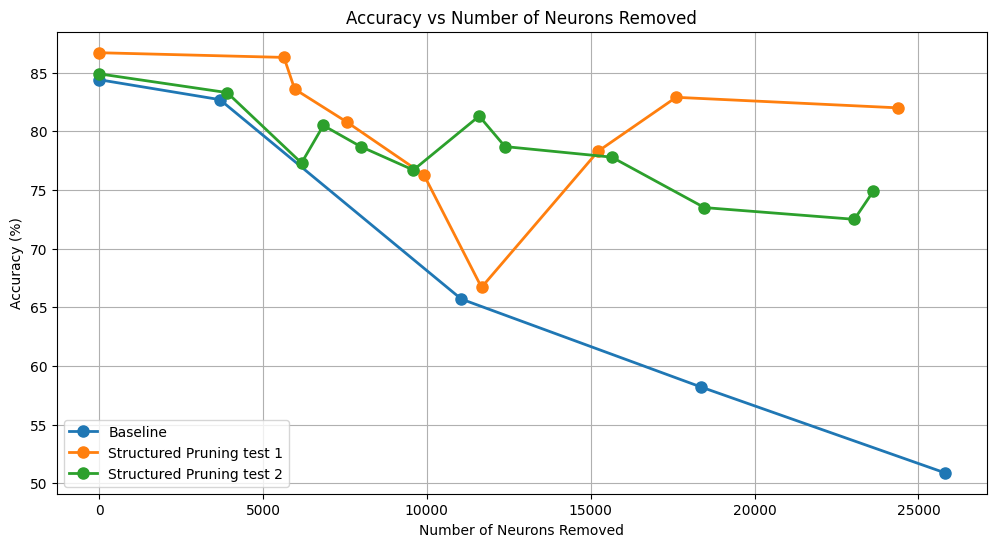

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

#test1 86.7, 86.3, 83.6, 80.8, 76.3, 66.7, 78.3, 83.7, 82.9, 82.0, 68.4
#test1 0, 5640, 5965, 7554, 9907, 11668, 15224, 13074, 17607, 24388, 23715

#test2 84.9, 83.3, 77.3, 80.5, 78.7, 76.7, 81.3, 78.7, 77.8, 73.5, 72.5, 74.9
#test2 20.69, 20.52, 20.53, 20.53, 10.93, 10.68, 10.69, 20.66, 20.52, 10.71, 20.52


data = {
    "Removed Neuron Numbers": [0, 3684, 11052, 18372, 25800, 0, 5640, 5965, 7554, 9907, 11668, 15224, 17607, 24388, 0, 3905, 6175, 6841, 7980, 9588, 11596, 12384, 15641, 18469, 23045, 23625],
    "Accuracy (%)": [84.4, 82.7, 65.7, 58.2, 50.9, 86.7, 86.3, 83.6, 80.8, 76.3, 66.7, 78.3, 82.9, 82.0, 84.9, 83.3, 77.3, 80.5, 78.7, 76.7, 81.3, 78.7, 77.8, 73.5, 72.5, 74.9],
    "Method": ["Baseline"]*5 + ["Structured Pruning test 1"]*9 + ["Structured Pruning test 2"]*12
}

# Creating DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 6))
for method in df["Method"].unique():
    subset = df[df["Method"] == method]
    plt.plot(subset["Removed Neuron Numbers"], subset["Accuracy (%)"], marker='o', markersize=8, label=method, linewidth=2)

plt.title("Accuracy vs Number of Neurons Removed")
plt.xlabel("Number of Neurons Removed")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

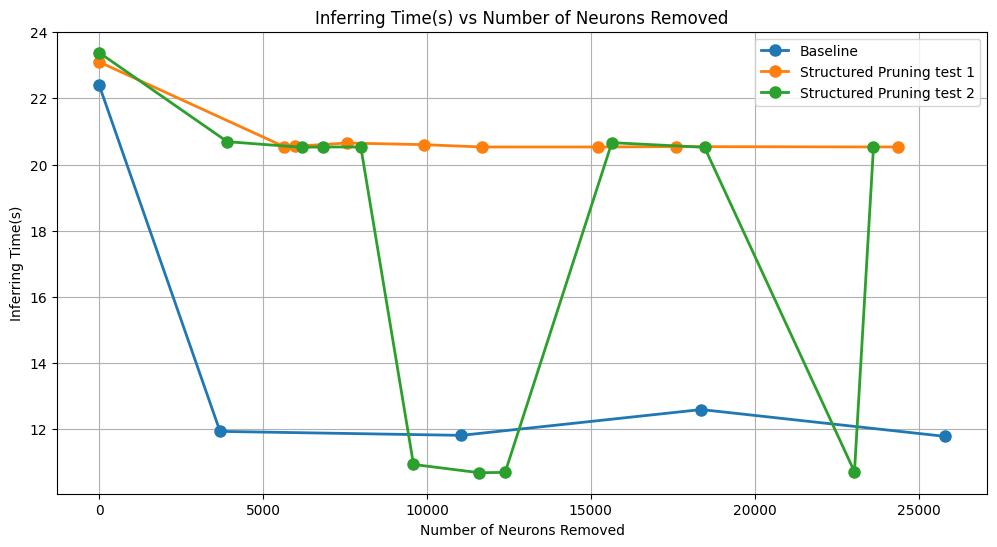

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

#test1 86.7, 86.3, 83.6, 80.8, 76.3, 66.7, 78.3, 83.7, 82.9, 82.0, 68.4
#test1 0, 5640, 5965, 7554, 9907, 11668, 15224, 13074, 17607, 24388, 23715
#      23.1, 20.54, 20.55, 20.65, 20.6, 20.53, 20.53, 12.98 20.54, 20.53, 12.54


#test2 84.9, 83.3, 77.3, 80.5, 78.7, 76.7, 81.3, 78.7, 77.8, 73.5, 72.5, 74.9
#test2 23.38, 20.69, 20.52, 20.53, 20.53, 10.93, 10.68, 10.69, 20.66, 20.52, 10.71, 20.52


data = {
    "Removed Neuron Numbers": [0, 3684, 11052, 18372, 25800, 0, 5640, 5965, 7554, 9907, 11668, 15224, 17607, 24388, 0, 3905, 6175, 6841, 7980, 9588, 11596, 12384, 15641, 18469, 23045, 23625],
    "Inferring Time(s)": [22.39, 11.93, 11.81, 12.59, 11.78, 23.1, 20.54, 20.55, 20.65, 20.6, 20.53, 20.53, 20.54, 20.53, 23.38, 20.69, 20.52, 20.53, 20.53, 10.93, 10.68, 10.69, 20.66, 20.52, 10.71, 20.52],
    "Method": ["Baseline"]*5 + ["Structured Pruning test 1"]*9 + ["Structured Pruning test 2"]*12
}

# Creating DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 6))
for method in df["Method"].unique():
    subset = df[df["Method"] == method]
    plt.plot(subset["Removed Neuron Numbers"], subset["Inferring Time(s)"], marker='o', markersize=8, label=method, linewidth=2)

plt.title("Inferring Time(s) vs Number of Neurons Removed")
plt.xlabel("Number of Neurons Removed")
plt.ylabel("Inferring Time(s)")
plt.legend()
plt.grid(True)
plt.show()